In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import joblib  # импортируем для сохранения модели

# Загрузка данных
df = pd.read_csv('Razmetka_Koments.csv')

# Определяем категории
category_columns = [
    'Вопрос решен',
    'Нравится качество выполнения заявки',
    'Нравится качество работы сотрудников',
    'Нравится скорость отработки заявок',
    'Понравилось выполнение заявки',
    'Другое'
]

# Создаем колонку с меткой категории
def get_category(row):
    for col in category_columns:
        if row[col] == 1:
            return col
    return None

df['category'] = df.apply(get_category, axis=1)

# Удаляем строки без метки
df = df.dropna(subset=['category'])

texts = df['comment'].astype(str)
labels = df['category']

# Кодируем категории
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels_encoded, test_size=0.2, random_state=42, stratify=labels
)

# Векторизация текста без NLTK
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Обучение модели логистической регрессии
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Получение вероятностей для ROC-AUC
y_score = model.predict_proba(X_test_tfidf)

# Расчет ROC-AUC по многоклассовой задаче
roc_auc = roc_auc_score(y_test, y_score, multi_class='ovr')
print(f'ROC-AUC: {roc_auc:.4f}')

# Сохранение модели и векторизатора в файл
joblib.dump({'model': model, 'vectorizer': vectorizer, 'label_encoder': label_encoder}, 'model.pth')
print("Модель и векторизатор сохранены в файл 'model.pth'.")

# Функция для предсказания категории по новому комментарию
def predict_category(comment):
    comment_tfidf = vectorizer.transform([comment])
    proba = model.predict_proba(comment_tfidf)[0]
    predicted_idx = np.argmax(proba)
    predicted_category = label_encoder.inverse_transform([predicted_idx])[0]
    probabilities = dict(zip(label_encoder.classes_, proba))
    return predicted_category, probabilities

# Цикл для повторного ввода комментариев с выводом
while True:
    user_comment = input("Введите ваш комментарий (или введите 'выход' для завершения): ")
    if user_comment.lower() == 'выход':
        print("Завершение работы.")
        break
    # Выводим строку с комментарием
    print(f"Комментарий пользователя: {user_comment}")
    predicted_category, probabilities = predict_category(user_comment)
    print(f"Предполагаемая категория: {predicted_category}")
    print('Вероятности по категориям:')
    for cat, prob in probabilities.items():
        print(f'{cat}: {prob:.4f}')
    print('------------------------------------------')
    
    # Для загрузки модели и векторизатора
data = joblib.load('model.pth')
model = data['model']
vectorizer = data['vectorizer']
label_encoder = data['label_encoder']

ROC-AUC: 0.9117
Модель и векторизатор сохранены в файл 'model.pth'.
Комментарий пользователя: спасибо
Предполагаемая категория: Вопрос решен
Вероятности по категориям:
Вопрос решен: 0.8986
Другое: 0.0075
Нравится качество выполнения заявки: 0.0084
Нравится качество работы сотрудников: 0.0451
Нравится скорость отработки заявок: 0.0328
Понравилось выполнение заявки: 0.0076
------------------------------------------
Комментарий пользователя: елена хороший мастер 
Предполагаемая категория: Нравится качество работы сотрудников
Вероятности по категориям:
Вопрос решен: 0.1434
Другое: 0.0584
Нравится качество выполнения заявки: 0.0469
Нравится качество работы сотрудников: 0.5609
Нравится скорость отработки заявок: 0.1594
Понравилось выполнение заявки: 0.0311
------------------------------------------
Комментарий пользователя: обработали очень быстро
Предполагаемая категория: Нравится скорость отработки заявок
Вероятности по категориям:
Вопрос решен: 0.1131
Другое: 0.0471
Нравится качество выпо

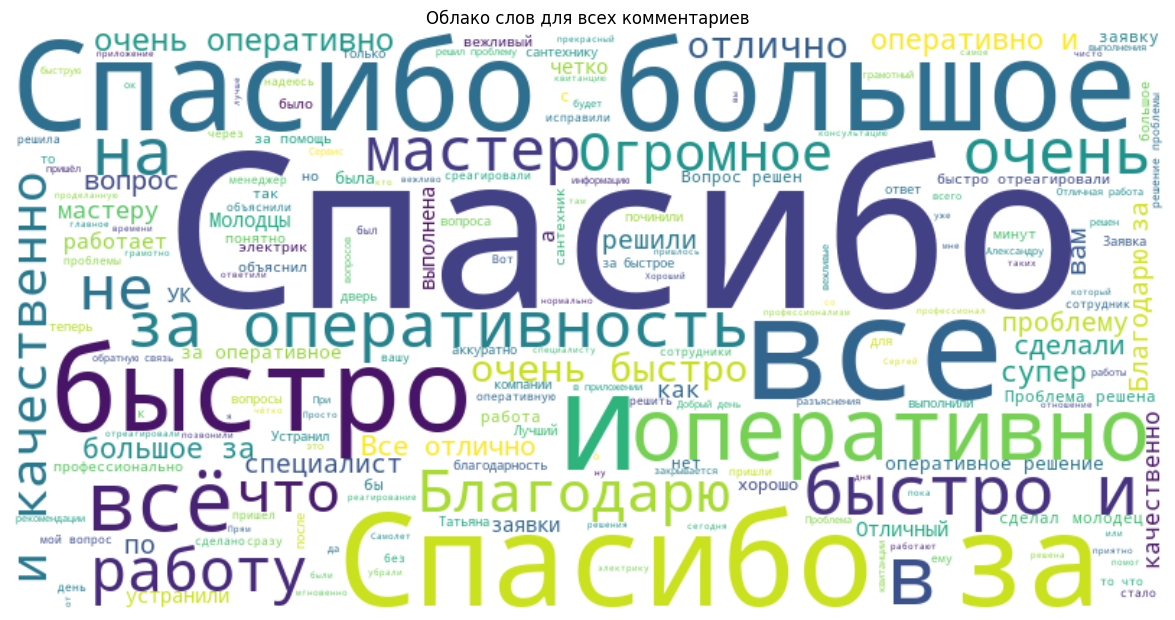

In [1]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Загрузка данных
df = pd.read_csv('Razmetka_Koments.csv')

# Объединяем все комментарии в один текст
comments = df['comment'].dropna().astype(str)
text = ' '.join(comments)

# Генерация облака слов
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Визуализация
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для всех комментариев')
plt.show()

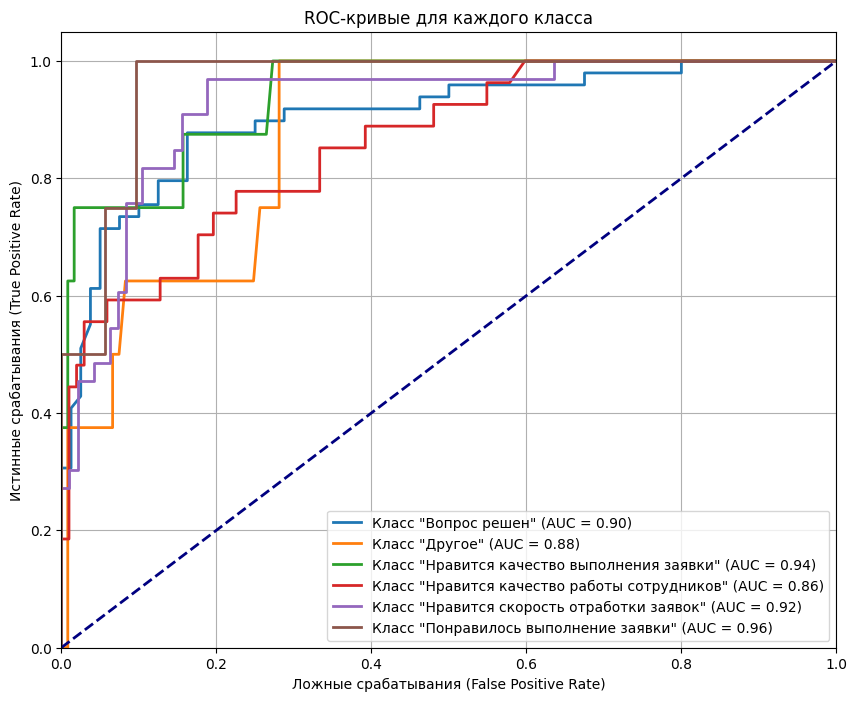

In [11]:
# После оценки модели
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Построение ROC-кривых для каждого класса
plt.figure(figsize=(10, 8))
for i in range(len(label_encoder.classes_)):
    fpr, tpr, _ = roc_curve(y_test == i, y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2,
             label=f'Класс "{label_encoder.classes_[i]}" (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ложные срабатывания (False Positive Rate)')
plt.ylabel('Истинные срабатывания (True Positive Rate)')
plt.title('ROC-кривые для каждого класса')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

C:\Users\~Шамиль\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\~Шамиль\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


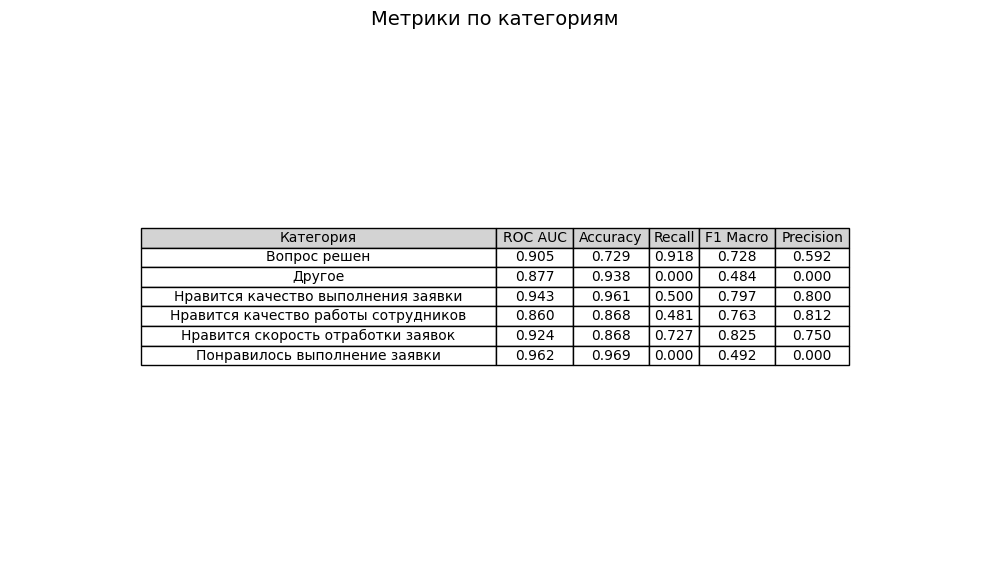

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, f1_score, precision_score
from sklearn.preprocessing import LabelEncoder

# Предполагается, что у вас есть:
# - обученная модель: model
# - тестовые данные: X_test_tfidf, y_test (кодированные метки)
# - метки категорий: label_encoder (уже обучен и содержит классы)

# Получение предсказаний и вероятностей по тестовым данным
y_pred = model.predict(X_test_tfidf)
y_proba = model.predict_proba(X_test_tfidf)
categories = label_encoder.classes_

# Создаем словарь для хранения метрик по категориям
metrics_results = {}

for idx, category in enumerate(categories):
    # Создаем бинарные метки для текущей категории
    y_true_cat = (y_test == idx).astype(int)  # Истинные метки для категории
    y_pred_cat = (y_pred == idx).astype(int)  # Предсказания модели для категории
    y_score_cat = y_proba[:, idx]  # Вероятности для категории

    # Вычисляем метрики
    roc_auc = roc_auc_score(y_true_cat, y_score_cat)
    accuracy = accuracy_score(y_true_cat, y_pred_cat)
    recall = recall_score(y_true_cat, y_pred_cat)
    f1_macro = f1_score(y_true_cat, y_pred_cat, average='macro')
    precision = precision_score(y_true_cat, y_pred_cat)

    # Заполняем словарь
    metrics_results[category] = {
        'roc_auc': roc_auc,
        'accuracy': accuracy,
        'recall': recall,
        'f1_macro': f1_macro,
        'precision': precision
    }

# Ваша функция для отображения таблицы
def plot_metrics_table(metrics_results):
    categories = list(metrics_results.keys())
    metrics_names = ['roc_auc', 'accuracy', 'recall', 'f1_macro', 'precision']

    # Формирую список значений по каждой метрике для всех категорий
    data = []
    for metric in metrics_names:
        metric_values = [metrics_results[cat][metric] for cat in categories]
        data.append(metric_values)

    data = np.array(data)

    # Создаю таблицу
    fig, ax = plt.subplots(figsize=(10, len(categories)*0.8 + 1))
    ax.axis('tight')
    ax.axis('off')

    # Подготавливаю данные для таблицы
    table_data = []
    for i, category in enumerate(categories):
        row = [category]
        for j in range(len(metrics_names)):
            row.append(f"{data[j][i]:.3f}")
        table_data.append(row)

    # Заголовки столбцов
    column_labels = ['Категория', 'ROC AUC', 'Accuracy', 'Recall', 'F1 Macro', 'Precision']

    # Создаю таблицу
    table = ax.table(cellText=table_data, colLabels=column_labels, loc='center', cellLoc='center', colColours=['lightgrey']*6)

    # Настраиваю стиль таблицы
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(6)))

    plt.title('Метрики по категориям', fontsize=14)
    plt.tight_layout()
    plt.show()

# Вызов функции для отображения
plot_metrics_table(metrics_results)